# Introduction
This notebook is testing how  μμ Merge handles ChIP-seq replicates in comparison to other merging techniques such as bedtools merge and bedtools intersect.


# Raw Reads Processing Pipeline

## Peak calling with MACS

- Raw ChIP-seq files were processed using the Dowell Labs ChIP-seq Nextflow pipeline (https://github.com/Dowell-Lab/ChIP-Flow).

- Peak calling with Macs2 was run on mapped reads

```sh
macs2 callpeak \
 -c $BAM_DIR/${CTRL1}.sorted.bam \
 -t $BAM_DIR/${NTLN1}.sorted.bam \
 --outdir $OUT \
 -n ${HCT116_2} \
 -g hs \
 -f BAM \
 -q 0.001
 
``` 

## Motif scanning with FIMO

- Transcription Motifs were scanned for based summit locations for each peak call

```sh
fimo -max-stored-scores 1000000 --thresh 1e-4 -oc ${outdir}/${bed} -motif $motiffile ${hocomoco}/HOCOMOCOv11_core_HUMAN_mono_meme_format.meme ${chip_fa}/${bed}_mac\
s.fa
```

## Merging Regions

- bedtools merge

- bedtools intersect

- muMerge 

# Load libraries

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('/Users/rusi2317/projects/mumerge_test/bin/mumerge_explore'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
pkg_dir='/Users/rusi2317/.local/lib/python3.6/site-packages/'
sys.path.append(os.path.abspath(pkg_dir))

In [2]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import entropy
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
from mumerge_explore.load_data import *
from mumerge_explore.plot_figures import *
from mumerge_explore.process_regions import *

## Filter regions for merging

In [4]:
andrysik_samples = ['HCT116_DMSO_TP53','HCT116_Nutlin_TP53',
                    'MCF7_DMSO_TP53','MCF7_Nutlin_TP53',
                   'SJSA_DMSO_TP53', 'SJSA_Nutlin_TP53']

motif = '/Users/rusi2317/projects/mumerge_test/processed_data/fimo_scans/'
peaks = '/Users/rusi2317/projects/mumerge_test/data/andrysik2017_peak_calls/'
outdir = '/Users/rusi2317/projects/mumerge_test/processed_data/significant_regions/'

for sample_name in andrysik_samples:
    
    fimo_hits = load_fimo(motif+sample_name+'_summits.bed/fimo.tsv')

    fimo_filtered = filter_fimo(fimo_hits, alpha=1e-03)

    fimo_filtered_unique = unique_sig_fimo(fimo_filtered)

    fimo_sig_summit_peaks = sig_summit_peaks(peaks+sample_name+'_summits.bed',
                                              fimo_filtered_unique)

    fimo_sig_narrow_peaks = final_narrow_peaks(peaks+sample_name+'_peaks.narrowPeak',
                                                fimo_sig_summit_peaks, outdir,sample_name+'_sigFimo.bed' )
    print(' ')

---------------------------------------------------------------------
--------------------- STORING FIMO RESULTS FILE ---------------------
-> Number of Fimo Calls = 1592
--------- FILTERING MOTIF HITS AT AN ALPHA LEVEL OF 0.001 ----------
------------------------- UNIQUE FIMO HITS --------------------------
-------------- SIGNIFICANT PEAKS WITH FIMO MOTIF HIT ----------------
-> Macs peaks called = 595
---------- SAVE NARROW PEAKS WITH SIGNIFICANT MOTIF HITS ------------
-> Peaks with significant hits = 558
------------------- DONE RUNNING HCT116_DMSO_TP53_sigFimo.bed -------------------
---------------------------------------------------------------------
 
---------------------------------------------------------------------
--------------------- STORING FIMO RESULTS FILE ---------------------
-> Number of Fimo Calls = 6113
--------- FILTERING MOTIF HITS AT AN ALPHA LEVEL OF 0.001 ----------
------------------------- UNIQUE FIMO HITS --------------------------
-------------- SIGNIFI

## Load bed files

In [4]:
merged_files = '/Users/rusi2317/projects/mumerge_test/processed_data/merged_regions/'

merged_bed = []

for file in os.listdir(merged_files):
    if file.endswith("MERGE.bed"):
        merged_bed.append(merged_files + file)
    elif file.endswith("intersect_recursive.bed"):
        merged_bed.append(merged_files + file) 
    else:
        pass

In [5]:
##since the merged regions were based on the peaks with significant motifs,
##It is a better comparison to use the significant regions bed than the original bed files 

#bed_files = '/Users/rusi2317/projects/mumerge_test/data/andrysik2017_peak_calls/'

#samples =  []

#for bed in os.listdir(bed_files):
#    if bed.endswith('_peaks.narrowPeak'):
#        samples.append(bed_files + bed)
#    else:
#        pass
    

In [5]:
##since the merged regions were based on the peaks with significant motifs,
##It is a better comparison to use the significant regions bed than the original bed files 

bed_files = '/Users/rusi2317/projects/mumerge_test/processed_data/significant_regions/'

samples =  []

for bed in os.listdir(bed_files):
    if bed.endswith('.bed'):
        samples.append(bed_files + bed)
    else:
        pass
    

In [6]:
all_files = [samples + merged_bed]

fetched_regions = []
region_ids = []

for bed_regions in all_files:
    for path in bed_regions:
        region = fetch_merged_regions(path)
        sample_id = str.split(str.split(str(path),'/')[-1], '_')
        fetched_regions.append(region)
        region_ids.append(sample_id)

In [7]:
all_files

[['/Users/rusi2317/projects/mumerge_test/processed_data/significant_regions/HCT116_Nutlin_TP53_sigFimo.bed',
  '/Users/rusi2317/projects/mumerge_test/processed_data/significant_regions/SJSA_DMSO_TP53_sigFimo.bed',
  '/Users/rusi2317/projects/mumerge_test/processed_data/significant_regions/MCF7_Nutlin_TP53_sigFimo.bed',
  '/Users/rusi2317/projects/mumerge_test/processed_data/significant_regions/MCF7_DMSO_TP53_sigFimo.bed',
  '/Users/rusi2317/projects/mumerge_test/processed_data/significant_regions/SJSA_Nutlin_TP53_sigFimo.bed',
  '/Users/rusi2317/projects/mumerge_test/processed_data/significant_regions/HCT116_DMSO_TP53_sigFimo.bed',
  '/Users/rusi2317/projects/mumerge_test/processed_data/merged_regions/Andrysik2017_mumerged.bed_BEDTOOLS_MERGE.bed',
  '/Users/rusi2317/projects/mumerge_test/processed_data/merged_regions/Andrysik2017_intersect_recursive.bed',
  '/Users/rusi2317/projects/mumerge_test/processed_data/merged_regions/Andrysik2017_mumerged.bed_MUMERGE.bed']]

In [8]:
mumerged = fetched_regions[8]
interset = fetched_regions[7]
btmerged = fetched_regions[6]

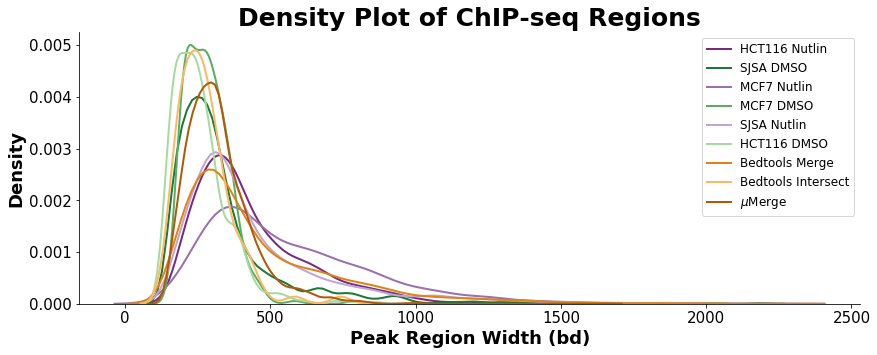

In [9]:
f = plt.figure(figsize=(14,5))

line_col = ['#762a83','#1b7837','#9970ab','#5aae61','#c2a5cf','#a6dba0',
           '#e08214','#fdb863','#b35806']

#region_ids_new = ['SJSA DMSO','SJSA Nutlin', 
#                  'SJSA DMSO','SJSA Nutlin',
#                  'SJSA DMSO','SJSA Nutlin', 'Bedtools Merge',
#                  'Bedtools Intersect',r'$\mu$Merge']

#line_col = ['','','','','','',]

region_ids_new = ['HCT116 Nutlin', 'SJSA DMSO', 'MCF7 Nutlin',
                  'MCF7 DMSO','SJSA Nutlin', 'HCT116 DMSO',
                  'Bedtools Merge','Bedtools Intersect',r'$\mu$Merge']

for regions, ids, cols in zip(fetched_regions, region_ids_new, line_col):
    
    ax00 = sns.distplot(regions, hist=False, kde=True,
                 bins=60, color = cols,
                 kde_kws={'shade': False,'linewidth': 2},
                 label=str(ids))
    ax00.spines['right'].set_visible(False)
    ax00.spines['top'].set_visible(False)
    
plt.legend(prop={'size': 12}, title = '')
plt.title('Density Plot of ChIP-seq Regions',fontsize=25,fontweight='bold')
plt.xlabel('Peak Region Width (bd)',fontsize=18,fontweight='bold')
plt.ylabel('Density',fontsize=18,fontweight='bold')
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

f.savefig("./figures/pdf/TP53_width_distributions.pdf", bbox_inches='tight')
f.savefig("./figures/png/TP53_width_distributions.png", bbox_inches='tight')

/opt/jupyterhub/venv/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


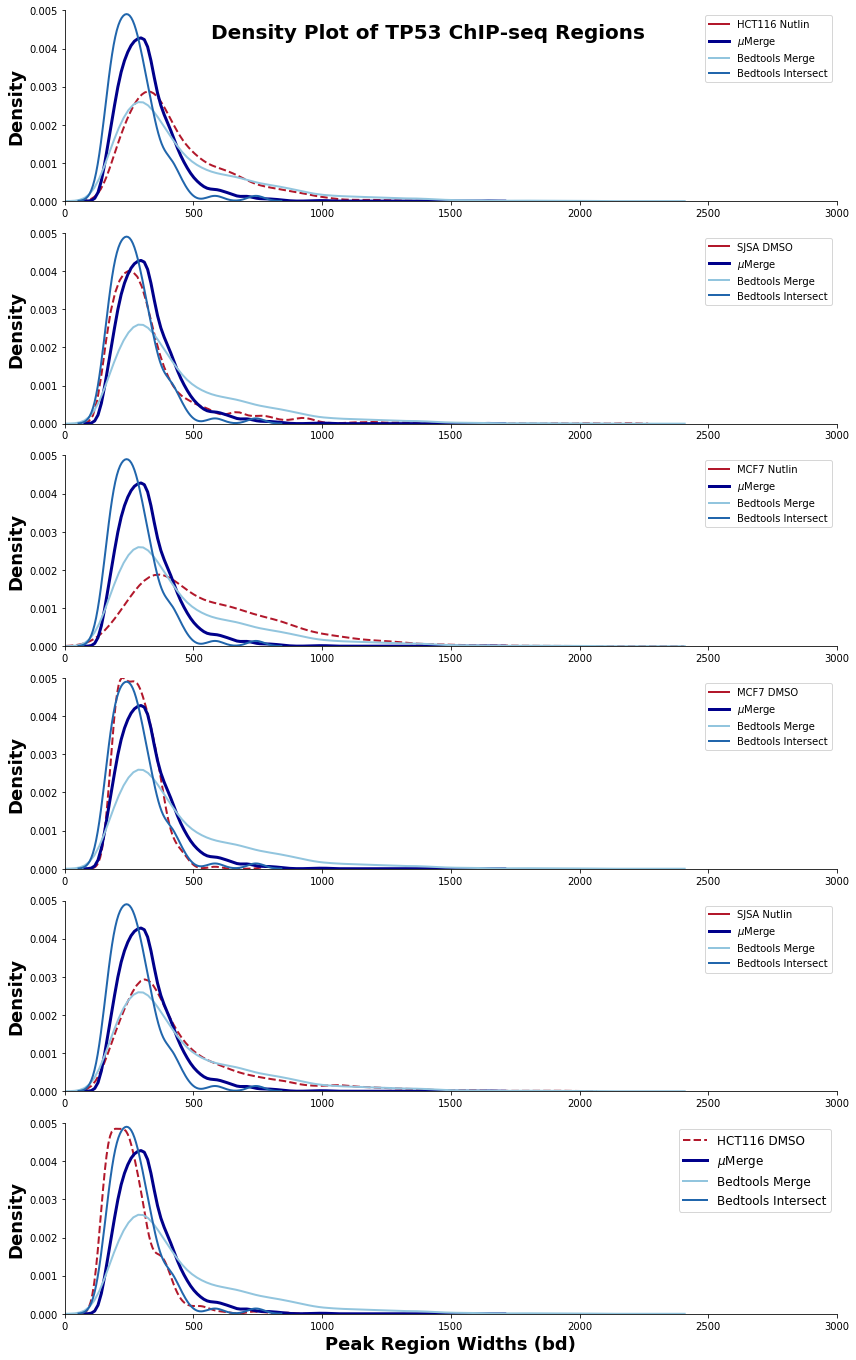

In [10]:
fig, axs = plt.subplots(nrows=6, figsize=(12,19))


for i in range(len(region_ids[0:6])):

        
        ax = sns.distplot(fetched_regions[i], hist=False, kde=True,rug = False, 
                     bins=60, color = '#b2182b', 
                     kde_kws={'shade': False,'linewidth': 2},
                     rug_kws={'color': '#b2182b'},
                     label=str(region_ids_new[i]),
                    ax=axs[i])
        
        ax = sns.distplot(mumerged, hist=False, kde=True,rug = False, 
                     bins=60, color = 'darkblue', 
                     kde_kws={'shade': False,'linewidth': 3},
                    rug_kws={'color': 'darkblue'},
                    label=r'$\mu$Merge',
                     ax=axs[i])

        ax = sns.distplot(btmerged, hist=False, kde=True,rug = False, 
                     bins=60, color = '#92c5de', 
                     kde_kws={'shade': False,'linewidth': 2},
                    rug_kws={'color': '#92c5de'},
                    label='Bedtools Merge',
                     ax=axs[i])

        ax = sns.distplot(interset, hist=False, kde=True,rug = False, 
                     bins=60, color = '#2166ac', 
                     kde_kws={'shade': False,'linewidth': 2},
                    rug_kws={'color': '#2166ac'},
                    label='Bedtools Intersect',
                     ax=axs[i])

        ax.lines[0].set_linestyle("--")
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        plt.legend(prop={'size': 12}, title = '')
        plt.xlabel('Peak Region Widths (bd)', fontsize=18, fontweight='bold')
        ax.set_ylabel('Density', fontsize=18, fontweight='bold')
        ax.set(xlim=(0, 3000))
        ax.set(ylim=(0, 0.005))

fig.suptitle('Density Plot of TP53 ChIP-seq Regions', fontsize=20, fontweight='bold')
fig.tight_layout()
fig.show()

fig.savefig("./figures/pdf/TP53_width_distributions_multi.pdf", bbox_inches='tight')
fig.savefig("./figures/png/TP53_width_distributions_multi.png", bbox_inches='tight')

/opt/jupyterhub/venv/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


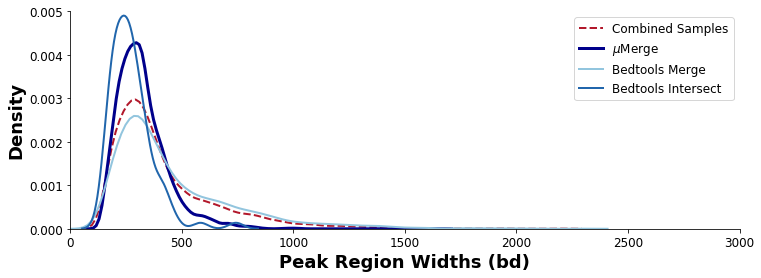

In [11]:
fig, ax_comb = plt.subplots(figsize=(12,4))
combined_samples = [j for i in fetched_regions[0:6] for j in i]


ax_comb = sns.distplot(combined_samples, hist=False, kde=True,rug = False, 
                  bins=60, color = '#b2182b', 
                  kde_kws={'shade': False,'linewidth': 2},
                  rug_kws={'color': '#b2182b'},
                  label= 'Combined Samples')

ax_comb = sns.distplot(mumerged, hist=False, kde=True,rug = False, 
                       bins=60, color = 'darkblue', 
                       kde_kws={'shade': False,'linewidth': 3},
                       rug_kws={'color': 'darkblue'},
                       label=r'$\mu$Merge')

ax_comb = sns.distplot(btmerged, hist=False, kde=True,rug = False, 
                       bins=60, color = '#92c5de', 
                       kde_kws={'shade': False,'linewidth': 2},
                       rug_kws={'color': '#92c5de'},
                       label='Bedtools Merge')

ax_comb = sns.distplot(interset, hist=False, kde=True,rug = False, 
                       bins=60, color = '#2166ac', 
                       kde_kws={'shade': False,'linewidth': 2},
                       rug_kws={'color': '#2166ac'},
                       label='Bedtools Intersect')

ax_comb.lines[0].set_linestyle("--")
ax_comb.spines['right'].set_visible(False)
ax_comb.spines['top'].set_visible(False)
ax_comb.set_ylabel('Density',fontsize=18,fontweight='bold')
ax_comb.set(xlim=(0, 3000))
ax_comb.set(ylim=(0, 0.005))

plt.legend(prop={'size': 12}, title = '')
plt.xlabel('Peak Region Widths (bd)',fontsize=18,fontweight='bold')

plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
fig.show()

fig.savefig("./figures/pdf/TP53_combined_reps_width_distributions.pdf", bbox_inches='tight')
fig.savefig("./figures/png/TP53_combined_reps_width_distributions.png", bbox_inches='tight')

### Kullback-Liebler Divergence 

In [12]:
#calculating the region densities
counts, bin_edges = np.histogram(mumerged, bins=60, density=True)

region_densities = []

for regions, ids in zip(fetched_regions, region_ids):
    
    cnt, bns = np.histogram(regions, bins=bin_edges, density=True)
    region_densities.append(cnt)

In [13]:
##calculating density distribution entropy
kl_results = []
kl_labels = []
for dens0, ids0 in zip(region_densities, region_ids):
    for dens1, ids1 in zip(region_densities, region_ids):
        
        constant = float(1e-30)
        kl = entropy(dens0+constant, dens1+constant, base=10)
        kl_results.append(float(kl))
        kl_labels.append([ids0, ids1, round(float(kl),2)])

In [14]:
##creating a 2D numpy array
n=9
kl_results_array = np.array([kl_results[i:i + n] for i in range(0, len(kl_results), n)])  
print(kl_results_array) 

[[  0.           0.17930435   0.06887968   6.79390818   0.02438534
    3.95908803   0.03116152  10.80983906   0.78641543]
 [  1.54925557   0.           1.53045806   4.23867214   1.36061513
    1.86788595   0.07940193   4.97320387   0.63150794]
 [  0.90505808   1.07040449   0.          11.47541954   0.12006824
    7.94097069   0.06548251  14.99665802   2.69276912]
 [  0.23479216   0.09464006   0.45434694   0.           0.20599271
    0.20484761   0.22087304   1.67515423   0.07031714]
 [  0.6020131    0.56602822   0.13010585   6.53888773   0.           4.30164716
    0.03020643  10.29431497   1.52219304]
 [  3.52304514   0.07765049   3.7011479    3.92202642   3.47083702   0.
    0.25801823   2.32658554   0.14437683]
 [  1.03838162   0.46704957   0.50931233   7.77794089   0.46638627
    4.93763312   0.          10.55066263   1.70290844]
 [  1.21533803   0.10998556   1.41201573   1.28008721   1.18100195
    0.38825455   0.25637415   0.           0.12088137]
 [  0.54611176   0.04979968   0.

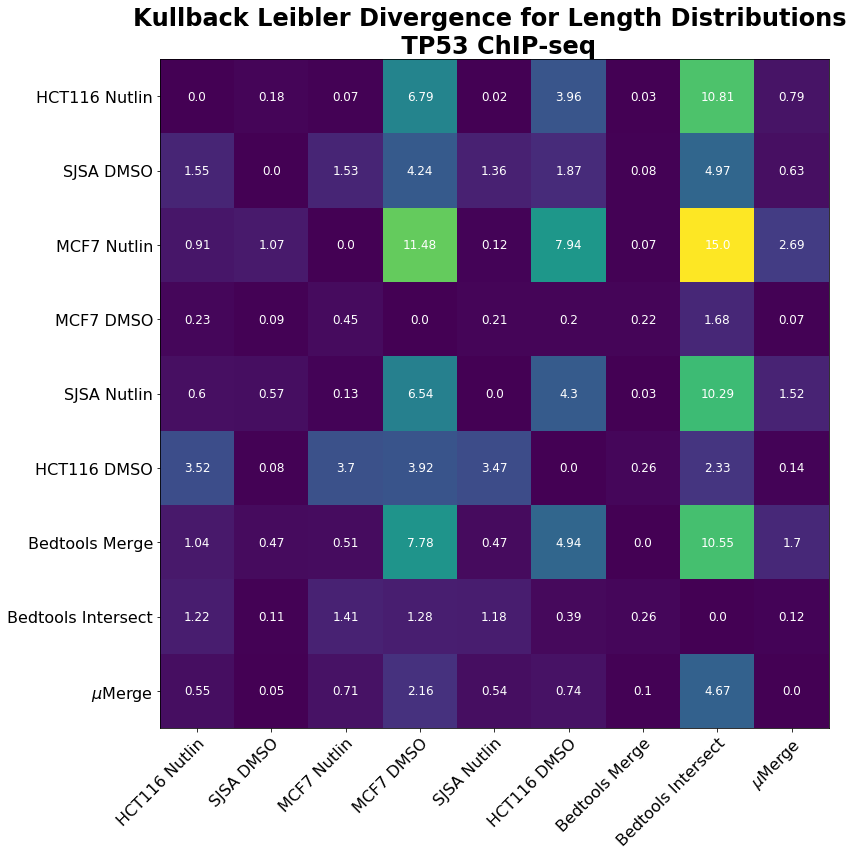

In [15]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(kl_results_array)
ax.set_title("Kullback Leibler Divergence for Length Distributions \n TP53 ChIP-seq",
            fontsize=24,fontweight='bold')

ax.set_xticks(np.arange(len(region_ids)))
ax.set_yticks(np.arange(len(region_ids)))

ax.set_xticklabels(region_ids_new, fontsize=16)
ax.set_yticklabels(region_ids_new, fontsize=16)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")


for i in range(len(region_ids)):
    for j in range(len(region_ids)):
        text = ax.text(j, i, round(kl_results_array[i, j],2),
                       ha="center", va="center", color="w",
                       fontsize=12)

fig.tight_layout()
plt.show()

fig.savefig("./figures/pdf/TP53_KL.pdf", bbox_inches='tight')
fig.savefig("./figures/png/TP53_KL.png", bbox_inches='tight')

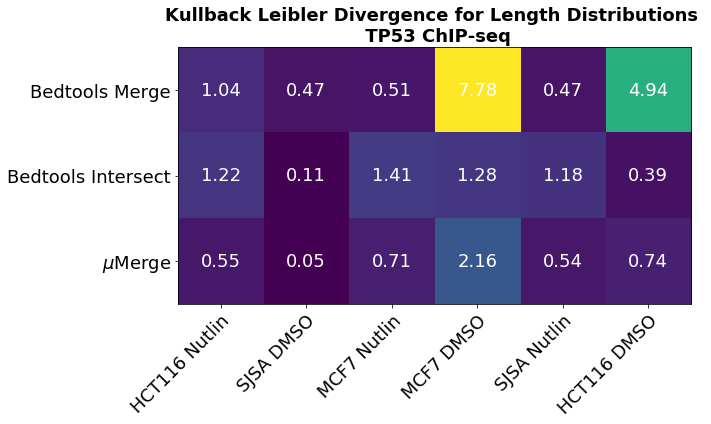

In [18]:
##filter mumerge comparisons with the samples
merge_kl = kl_results_array[6:9,0:6]

fig, ax = plt.subplots(figsize=(12, 6))
ax.imshow(merge_kl)
ax.set_title("Kullback Leibler Divergence for Length Distributions \n TP53 ChIP-seq",
            fontsize=18,fontweight='bold')

ax.set_xticks(np.arange(6))
ax.set_yticks(np.arange(3))

ax.set_xticklabels(region_ids_new[0:6],fontsize=18)
ax.set_yticklabels(region_ids_new[6:9],fontsize=18)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")


for i in range(3):
    for j in range(6):
        text = ax.text(j, i, round(merge_kl[i, j],2),
                       ha="center", va="center", color="w",
                       fontsize=18)

fig.tight_layout()
plt.show()

fig.savefig("./figures/pdf/TP53_KL_truncated.pdf", bbox_inches='tight')
fig.savefig("./figures/png/TP53_KL_truncated.png", bbox_inches='tight')

In [19]:
combined_regions = [combined_samples] + [btmerged] + [interset] + [mumerged] 
combined_ids = ['Combined Replicates','Bedtools Merge', 'Bedtools Intersect', r'$\mu$Merge']

##using the bin edges from the mumerge regions
counts, bin_edges = np.histogram(mumerged, bins=60, density=True)

combined_region_densities = []

for regions, ids in zip(combined_regions, combined_ids):
    
    cnt, bns = np.histogram(regions, bins=bin_edges, density=True)
    combined_region_densities.append(cnt)

In [20]:
## Kullback-Liebler Divergence 
kl_results_comb = []
kl_labels_comb = []
for dens0, ids0 in zip(combined_region_densities, combined_ids):
    for dens1, ids1 in zip(combined_region_densities, combined_ids):
        
        constant = float(1e-30)
        kl = entropy(dens0+constant, dens1+constant, base=10)
        kl_results_comb.append(float(kl))
        kl_labels_comb.append([ids0, ids1])

In [21]:
n=4
x_comb = np.array([kl_results_comb[i:i + n] for i in range(0, len(kl_results_comb), n)])  
print(x_comb) 

[[  0.00000000e+00   1.03327023e-02   9.03490509e+00   1.13252948e+00]
 [  7.72778050e-03   0.00000000e+00   1.05506626e+01   1.70290844e+00]
 [  2.10038229e-01   2.56374154e-01   0.00000000e+00   1.20881367e-01]
 [  7.05252209e-02   1.00018766e-01   4.67052524e+00   0.00000000e+00]]


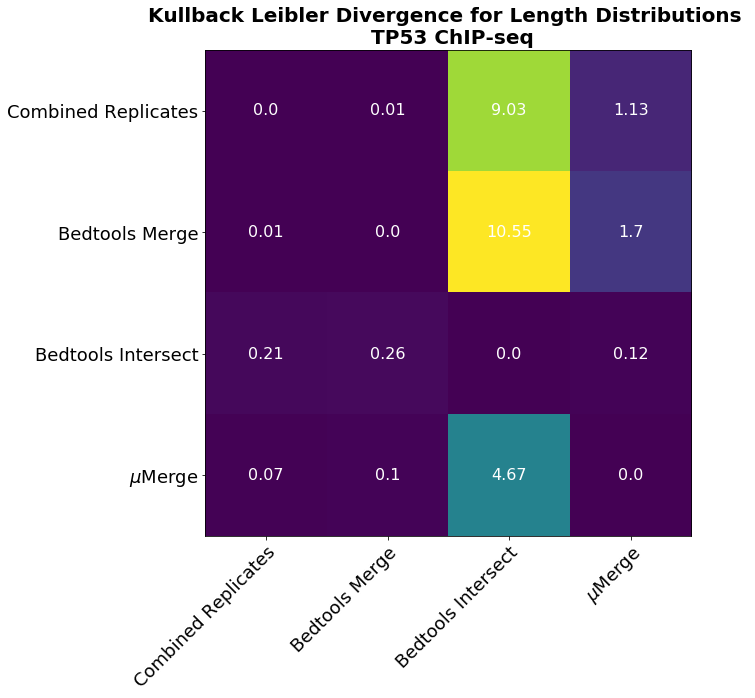

In [22]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(x_comb)
ax.set_title("Kullback Leibler Divergence for Length Distributions \n TP53 ChIP-seq",
            fontsize=20,fontweight='bold')

ax.set_xticks(np.arange(len(combined_ids)))
ax.set_yticks(np.arange(len(combined_ids)))

ax.set_xticklabels(combined_ids,fontsize=18)
ax.set_yticklabels(combined_ids,fontsize=18)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

for i in range(len(combined_ids)):
    for j in range(len(combined_ids)):
        text = ax.text(j, i, round(x_comb[i, j],2),
                       ha="center", va="center", color="w",
                       fontsize=16)

fig.tight_layout()
plt.show()

fig.savefig("./figures/pdf/TP53_KL_combined_reps.pdf", bbox_inches='tight')
fig.savefig("./figures/png/TP53_KL_combined_reps.png", bbox_inches='tight')

## Surveying Motif - Summit distances

In [23]:
##individual samples
andrysik_samples = ['HCT116_DMSO_TP53','HCT116_Nutlin_TP53',
                    'MCF7_DMSO_TP53','MCF7_Nutlin_TP53',
                   'SJSA_DMSO_TP53', 'SJSA_Nutlin_TP53']

sample_summits = '/Users/rusi2317/projects/mumerge_test/data/andrysik2017_peak_calls/' 
sample_narrow = '/Users/rusi2317/projects/mumerge_test/data/andrysik2017_peak_calls/' 
sample_fimo = '/scratch/Users/rusi2317/projects/mumerge_test/processed_data/fimo_scans_whole_seq/' 

sample_distances = []

for sample_name in andrysik_samples:
    print('---------------------------------------------------------------------')
    print(".......Assessing......." + sample_name)
    
    #load files
    macs_summit = load_bed(sample_summits + sample_name + '_summits.bed')
    macs_results = load_bed(sample_narrow + sample_name +'_peaks.narrowPeak')
    fimo_hits = load_fimo(sample_fimo + sample_name + '_peaks.narrowPeak/fimo.tsv')
    
    #filter regions
    fimo_filtered = filter_fimo(fimo_hits, alpha=1e-03)
    
    fimo_filtered_unique = unique_sig_fimo_hits(fimo_filtered)
    
    #calculate distances between peaks and TF motif
    motif_peak_dist = summit_motif_dist(macs_results, macs_summit, fimo_filtered_unique)
    
    sample_distances.append(motif_peak_dist)
    
    print('.....DONE processing.....' + sample_name)
    print('---------------------------------------------------------------------')
    print(' ')
    

---------------------------------------------------------------------
.......Assessing.......HCT116_DMSO_TP53
---------------------------------------------------------------------
--------------------- STORING FIMO RESULTS FILE ---------------------
-> Number of Fimo Calls = 1582
--------- FILTERING MOTIF HITS AT AN ALPHA LEVEL OF 0.001 ----------
Sequences with motif hits => 568
.....DONE processing.....HCT116_DMSO_TP53
---------------------------------------------------------------------
 
---------------------------------------------------------------------
.......Assessing.......HCT116_Nutlin_TP53
---------------------------------------------------------------------
--------------------- STORING FIMO RESULTS FILE ---------------------
-> Number of Fimo Calls = 13902
--------- FILTERING MOTIF HITS AT AN ALPHA LEVEL OF 0.001 ----------
Sequences with motif hits => 3029
.....DONE processing.....HCT116_Nutlin_TP53
---------------------------------------------------------------------
 


In [28]:
merge_samples = ['Andrysik2017_intersect_recursive.bed',
                 'Andrysik2017_merged.bed',
                 'Andrysik2017_mumerged.bed_MUMERGE.bed']

summary_narrow = '/scratch/Users/rusi2317/projects/mumerge_test/processed_data/merged_regions/' 
summary_fimo = '/scratch/Users/rusi2317/projects/mumerge_test/processed_data/fimo_scans_whole_seq/' 

merge_distances = []
merge_motif_sig = []

for sample_name in merge_samples:
    print('---------------------------------------------------------------------')
    print(".......Assessing......." + sample_name)
    
    #load files
    merged_narrow = merged_center(summary_narrow + sample_name) 
    merged_summit = merged_center_bed(merged_narrow)
    merged_fimo = load_fimo(summary_fimo + sample_name + '/fimo.tsv')
    
    #filter regions
    fimo_filtered = filter_fimo(merged_fimo, alpha=1e-03)
    
    fimo_filtered_unique = unique_sig_fimo_hits(fimo_filtered)
    
    #calculate distances between peaks and TF motif
    motif_peak_dist, motif_sig = summit_motif_dist(merged_narrow, merged_summit, fimo_filtered_unique)
    
    merge_distances.append(motif_peak_dist)
    merge_motif_sig.append(motif_sig)
    
    print('.....DONE processing.....' + sample_name)
    print('---------------------------------------------------------------------')
    print(' ')
    

---------------------------------------------------------------------
.......Assessing.......Andrysik2017_intersect_recursive.bed
---------------------------------------------------------------------
--------------------- STORING FIMO RESULTS FILE ---------------------
-> Number of Fimo Calls = 259
--------- FILTERING MOTIF HITS AT AN ALPHA LEVEL OF 0.001 ----------
Sequences with motif hits => 87
.....DONE processing.....Andrysik2017_intersect_recursive.bed
---------------------------------------------------------------------
 
---------------------------------------------------------------------
.......Assessing.......Andrysik2017_merged.bed
---------------------------------------------------------------------
--------------------- STORING FIMO RESULTS FILE ---------------------
-> Number of Fimo Calls = 7803
--------- FILTERING MOTIF HITS AT AN ALPHA LEVEL OF 0.001 ----------
Sequences with motif hits => 3058
.....DONE processing.....Andrysik2017_merged.bed
-------------------------

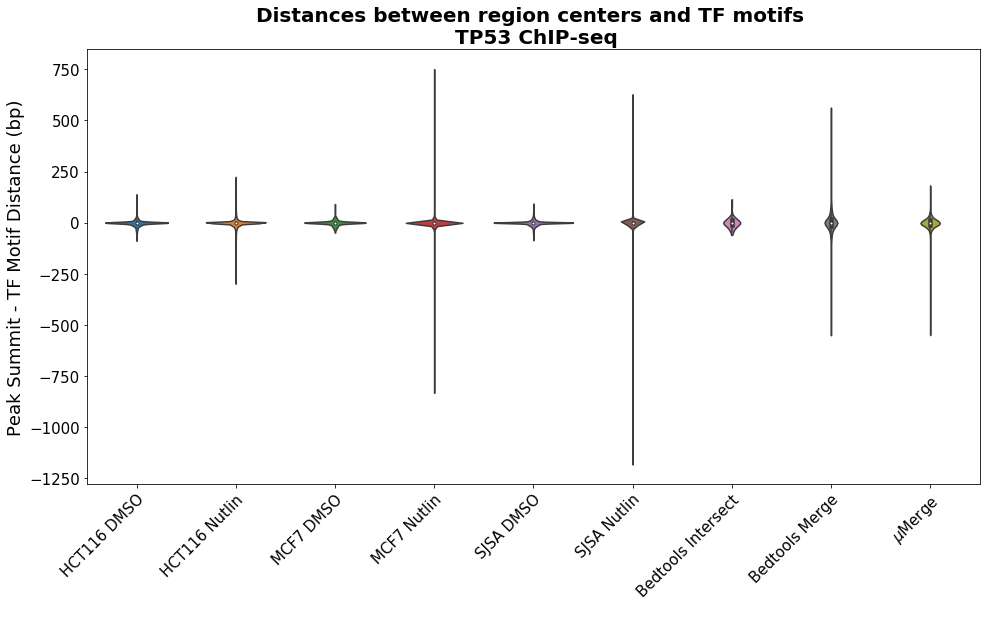

In [31]:
total_distances = sample_distances + merge_distances

total_ids = ['HCT116 DMSO','HCT116 Nutlin',
             'MCF7 DMSO','MCF7 Nutlin',
             'SJSA DMSO', 'SJSA Nutlin',
             'Bedtools Intersect', 
            'Bedtools Merge',
            r'$\mu$Merge']

fig, ax05 = plt.subplots(figsize=(16, 8))

ax05 = sns.violinplot(data=total_distances, cut=0, inner='box')
ax05.set_xticklabels(total_ids, rotation=45, ha="right",
         rotation_mode="anchor")

ax05.set_title('Distances between region centers and TF motifs \n TP53 ChIP-seq',
             fontsize=20, fontweight='bold')
ax05.set_xlabel(' ')
ax05.set_ylabel('Peak Summit - TF Motif Distance (bp)',fontsize=18)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

fig.savefig("./figures/pdf/TP53_RegionCenter_Motif_distances.pdf", bbox_inches='tight')
fig.savefig("./figures/png/TP53_RegionCenter_Motif_distances.png", bbox_inches='tight')

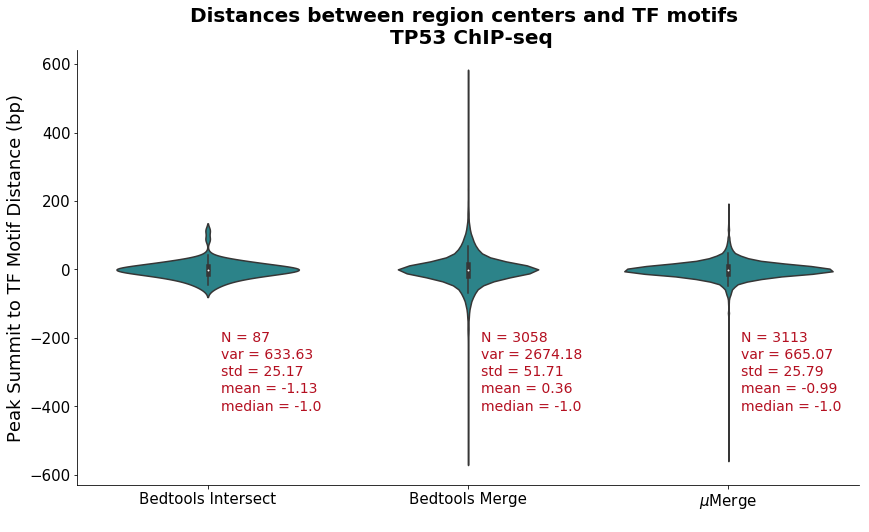

In [32]:
fig, ax06 = plt.subplots(figsize=(14, 8))

variance = []

for v in total_distances:
    var = np.var(v)
    variance.append(var)
    
for s in total_distances:
    std = np

ax06 = sns.violinplot(data=total_distances[6:], inner='box',color='#1c9099')
ax06.set_xticklabels(total_ids[6:])

ax06.set_title('Distances between region centers and TF motifs \n TP53 ChIP-seq',
             fontsize=20, fontweight='bold')
ax06.set_xlabel(' ')
ax06.set_ylabel('Peak Summit to TF Motif Distance (bp)',fontsize=18)

ax06.spines['right'].set_visible(False)
ax06.spines['top'].set_visible(False)
plt.legend(prop={'size': 12}, title = '')
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

for i, j, k in zip([0.05,1.05,2.05], variance[6:], [6,7,8]):
    text = ax06.text(i, -200, 'N = ' + str(len(total_distances[k])),
                        ha="left", va="center", color="#B40F20",
                        fontsize=14)
    text = ax06.text(i, -250, 'var = ' + str(round(j, 2)),
                       ha="left", va="center", color="#B40F20",
                       fontsize=14)
    text = ax06.text(i, -300, 'std = ' + str(round(np.std(total_distances[k]),2)),
                       ha="left", va="center", color="#B40F20",
                       fontsize=14)
    text = ax06.text(i, -350, 'mean = ' + str(round(np.mean(total_distances[k]),2)),
                       ha="left", va="center", color="#B40F20",
                       fontsize=14)
    text = ax06.text(i, -400, 'median = ' + str(round(np.median(total_distances[k]),2)),
                       ha="left", va="center", color="#B40F20",
                       fontsize=14)
    
fig.savefig("./figures/pdf/TP53_merged_RegionCenter_Motif_distances.pdf", bbox_inches='tight')
fig.savefig("./figures/png/TP53_merged_RegionCenter_Motif_distances.png", bbox_inches='tight')

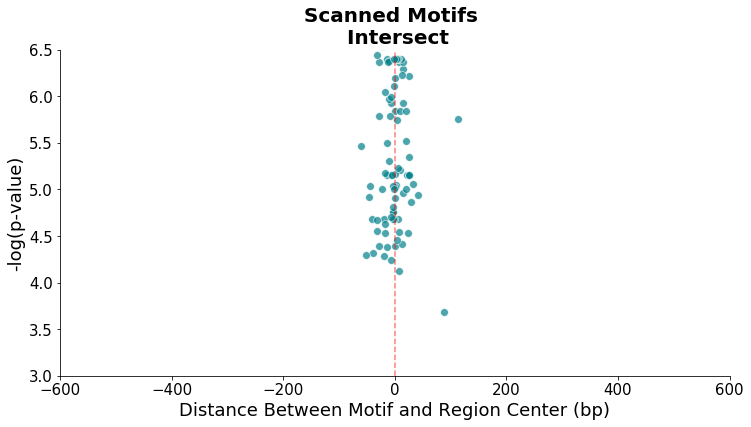

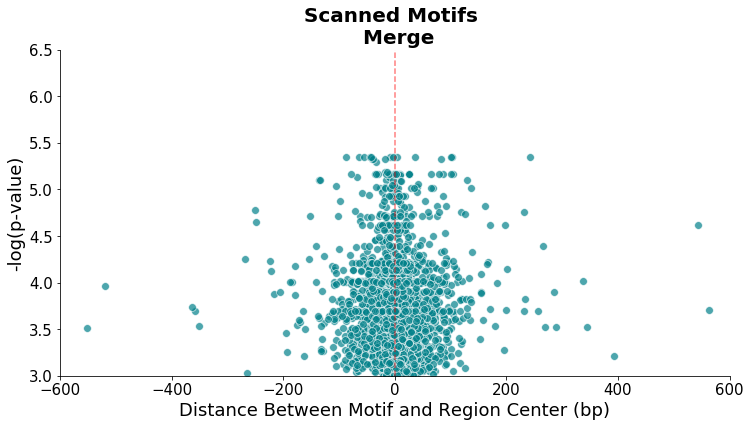

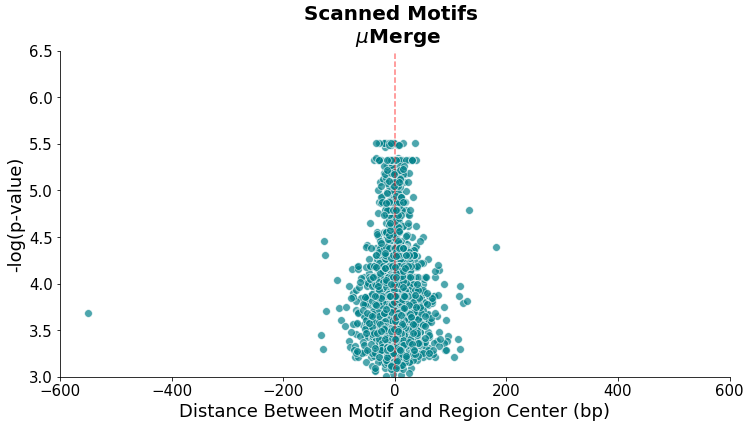

In [35]:
merge_samples_ids = ['Intersect', 'Merge', r'$\mu$Merge']


for dist, sig, label in zip(merge_distances, merge_motif_sig, merge_samples_ids):
  
    fig, ax0 = plt.subplots(figsize=(12, 6))

    ax08 = sns.scatterplot(x=dist, y=-np.log10(sig), s=60,color='#02818a', alpha=0.7)
    ax08.axvline(0, ls='--', color='red', linewidth=1.5, alpha=.5)
    ax08.set_title('Scanned Motifs \n {}'.format(label),
                 fontsize=20, fontweight='bold')
    ax08.set_xlabel('Distance Between Motif and Region Center (bp)',fontsize=18)
    ax08.set_ylabel('-log(p-value)',fontsize=18)
    ax08.spines['right'].set_visible(False)
    ax08.spines['top'].set_visible(False)
    plt.legend(prop={'size': 12}, title = '')
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    ax08.set(xlim=(-600, 600))
    ax08.set(ylim=(3, 6.5))
    
    fig.savefig("./figures/pdf/TP53_merged_RegionCenter_Motif_distances_{}.pdf".format(label), bbox_inches='tight')
    fig.savefig("./figures/png/TP53_merged_RegionCenter_Motif_distances_{}.png".format(label), bbox_inches='tight')